# Feature Extraction

Features to extract from data:
1. Highest amplitude peak
2. Next/previous valley and peak in relation to 1
3. Energy - square all values in array and sum
4. Entropy - take negative of - summation of value * log(value)
5. Peak to peak distance (average, std)
6. Peak amplitude (average, std)

In [1]:
#Import to process file
import pandas as pd
import csv
import os
import numpy as np
import matplotlib.pyplot as plt

#File directory
file_directory = "Raw Data/Sitting_Down_Acc/"
file_list = os.listdir(file_directory)

#Read file 
file = pd.read_csv(file_directory + file_list[3], header = None, sep = ';',  names = ['timestamp','x','y','z'], parse_dates = ['timestamp'])
file.head()

#Truncate last 500 samples due to noise 
file = file[:-800]

#Truncate first 100 samples due to noise
file = file[100:]

#Time dataframe
time = file['timestamp']

#Positional datafram
position = file.drop(['timestamp'], axis = 1)

#Normalize data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Store normalized data in new variable
position = scaler.fit_transform(position)

In [138]:
"""
This method will compute a rolling mean and apply it to the array
through division
"""
def rolling_mean_sub(arr, window):
    
    mean_arr = []
    arr_len = arr.shape[0]
    n_windows = int(arr_len/window)
    
    for win in range(arr_len):
        start = win
        end = start + window
        mean_arr.append(np.mean(arr[start:end]))
        
    new_arr = arr-mean_arr
    
    return new_arr


In [145]:
#Buterworth filter
from scipy import signal

fs = 50
lowcut = 4
highcut = 11

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

#Apply to y axis data points 
y_position = rolling_mean_sub(position[:,1], 3)

# First, design the Buterworth filter
N  = 4 # Filter order
Wn = [low, high] # Cutoff frequency
B, A = signal.butter(N, Wn, btype = 'bandpass' , output='ba')
 
# Second, apply the filter
y_filter = signal.filtfilt(B,A, y_position)


In [200]:
from scipy import signal

"""
Returns max value in array
"""
def max_peak(arr):
    return max(arr)

"""
Returns max value in array
"""
def min_peak(arr):
    return min(arr)


"""
Returns previous max peak value
"""
def previous_max_peak(arr):

    #Gets index of max value
    max_index = np.argmax(arr)
    
    #Creates new array 
    new_arr = arr[0:max_index]
    
    if len(new_arr) <= 3:
        prev_max = max(arr)
    else:
        #Gets top 5 indexes for next max value
        top_five = new_arr.argsort()[-4:][::-1]

        #Determines how far each value is from max
        diff_arr = (max_index - top_five)

        #Takes out values that are 1 sample away
        diff_arr_2 = diff_arr[diff_arr > 1]

        #Get the closest value 
        min_diff_arr = min(diff_arr_2)

        #Gets index of the closest value
        final_index = max_index - min_diff_arr

        #Gets value of previous max peak
        prev_max = arr[final_index]

    return prev_max


"""
Returns previous min peak value
"""
def previous_min_peak(arr):

    #Gets index of max value
    max_index = np.argmax(arr)
    
    #Creates new array 
    new_arr = arr[0:max_index]
    
    
    if len(new_arr) <= 3:
        prev_min = min(arr)
        
    else:
    
        #Gets top 5 indexes for max value
        top_five = new_arr.argsort()[-4:][::-1]

        #Determines how far each value is from max
        diff_arr = (max_index - top_five)

        #Takes out values that are 1 sample away
        diff_arr_2 = diff_arr[diff_arr > 1]

        #Get the closest value 
        min_diff_arr = min(diff_arr_2)

        #Gets index of the closest value
        final_max_index = max_index - min_diff_arr

        #Slices dataframe to easily find lowest peak
        new_arr_2 = arr[final_max_index:max_index]

        #Gets value of previous min peak
        prev_min = min(new_arr_2)

    return prev_min

"""
Returns previous max peak value
"""
def next_max_peak(arr):

    #Gets index of max value
    max_index = np.argmax(arr)
    
    #Creates new array 
    new_arr = arr[max_index:]
    
    if len(new_arr) <= 3:
        prev_max = max(arr)
    else:
        #Gets top 5 indexes for next max value
        top_five = new_arr.argsort()[-4:][::-1]

        #Takes out values that are 1 sample away
        diff_arr_2 = top_five[top_five > 1]

        #Get the closest value 
        min_diff_arr = min(diff_arr_2)

        #Gets index of the closest value
        final_index = max_index + min_diff_arr

        #Gets value of previous max peak
        next_max = arr[final_index]

    return next_max


"""
Returns previous min peak value
"""
def next_min_peak(arr):

    #Gets index of max value
    max_index = np.argmax(arr)
    
    #Creates new array 
    new_arr = arr[max_index:]
    
    
    if len(new_arr) <= 3:
        prev_min = min(arr)
        
    else:
    
        #Gets top 5 indexes for max value
        top_five = new_arr.argsort()[-4:][::-1]

        #Takes out values that are 1 sample away
        diff_arr_2 = top_five[top_five > 1]

        #Get the closest value 
        min_diff_arr = min(diff_arr_2)

        #Gets index of the closest value
        final_max_index = max_index + min_diff_arr

        #Slices dataframe to easily find lowest peak
        new_arr_2 = arr[max_index:final_max_index]

        #Gets value of previous min peak
        next_min = min(new_arr_2)

    return next_min


def energy(arr):
    
    #Squares every value in array
    squared = arr ** 2
    
    #Sums all values in array
    sum_squared = sum(squared)
    
    return sum_squared

def entropy(arr):
    
    total_sum = 0
    
    for value in arr:
        
        inner_eq = value * np.log10(abs(value))
        total_sum += inner_eq
    
    return -total_sum

def dist_bw_top_2_peaks(arr):
    
    #Gets top 2 indexes for next min value
    top_two = arr.argsort()[-2:][::-1]
    
    #Computes difference between peaks
    diff = top_two[1] - top_two[0]
    
    return diff

def dist_bw_top_3_peaks_avg(arr):
    
    #Gets top 3 indexes for next min value
    top_three = arr.argsort()[-3:][::-1]
    
    #Computes difference between peaks
    diff_1 = abs(top_three[2] - top_three[1])
    diff_2 = abs(top_three[2] - top_three[0])
    diff_3 = abs(top_three[1] - top_three[0])
    
    return np.mean([diff_1, diff_2, diff_3])

def dist_bw_top_3_peaks_std(arr):
    
    #Gets top 3 indexes for next min value
    top_three = arr.argsort()[-3:][::-1]
    
    #Computes difference between peaks
    diff_1 = abs(top_three[2] - top_three[1])
    diff_2 = abs(top_three[2] - top_three[0])
    diff_3 = abs(top_three[1] - top_three[0])
    
    return np.std([diff_1, diff_2, diff_3])
    
def top_2_amp(arr):
    
    #Gets top 2 indexes for next min value
    top_two = arr.argsort()[-2:][::-1]
    
    val_1 = arr[top_two[0]]
    val_2 = arr[top_two[1]]
    
    return np.mean([val_1, val_2])

def bottom_2_amp(arr):
    
    #Gets top 2 indexes for next min value
    top_two = arr.argsort()[:2][::-1]
    
    val_1 = arr[top_two[0]]
    val_2 = arr[top_two[1]]
    
    return np.mean([val_1, val_2])

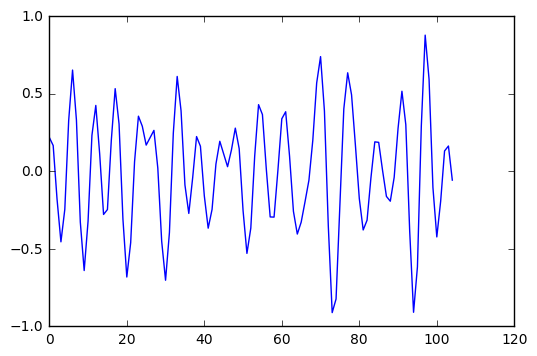

-0.910776423437 0.879378293653 -0.908596068955 0.636434125894 14.4647236467 0.950143163392
0.132142917014 -0.422452137581
-27 60.6666666667 26.2339898266 0.810144661686 -0.909686246196


In [201]:
#Test all functions

test = y_filter[100:205]

#Plot 
plt.plot(y_filter[100:205])
plt.show()

print(min_peak(test), max_peak(test), previous_min_peak(test), previous_max_peak(test), energy(test), entropy(test))
print(next_max_peak(test), next_min_peak(test))
print(dist_bw_top_2_peaks(test), dist_bw_top_3_peaks_avg(test), dist_bw_top_3_peaks_std(test), top_2_amp(test), bottom_2_amp(test))